In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
import scipy.stats
import scipy.optimize
from datetime import datetime
import pylandau

import uproot

from ipywidgets import IntProgress
from IPython.display import display

matplotlib.rcParams['figure.figsize'] = [12,8]
matplotlib.rcParams['axes.labelsize'] = 'x-large'


In [2]:
df = pd.read_pickle('test_data/mip.pkl')
df.channel.unique()

array([ 0, 32, 33, 34, 35, 36, 38, 40, 42, 43])

(array([   9.94151904, -392.01222985]), array([[ 1.32467840e-05, -3.15047968e-03],
       [-3.15047968e-03,  8.06827742e-01]]))
(array([   9.46156209, -433.37422628]), array([[ 3.65446717e-05, -4.18714144e-03],
       [-4.18714144e-03,  5.25154868e-01]]))


channel
33      [9.9415190416727, -392.01222984574764]
34    [9.461562087937843, -433.37422628127996]
dtype: object

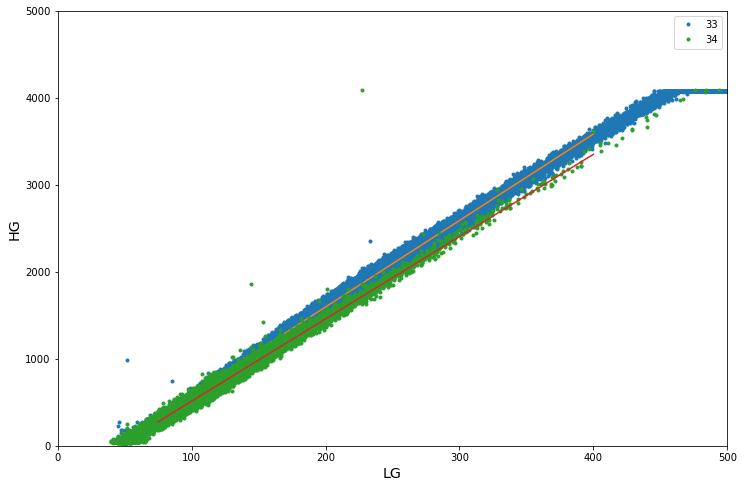

In [7]:
def plot_channel(df):
    fit_range_hg = np.array([75,4000])
    df_fit = df.loc[(df.HG > fit_range_hg[0]) & (df.HG < fit_range_hg[1])]

    def linear(x, a, b):
        return a*x+b
    
    fit = scipy.optimize.curve_fit(linear,  df_fit.LG, df_fit.HG, p0=(10,-100))
    print(fit)

    plt.plot(df.LG, df.HG, '.', label=df.channel.unique()[0])
    plt.xlabel('LG')
    plt.ylabel('HG')

    fit_range_lg = np.array([75,400])
    plt.plot(fit_range_lg, linear(fit_range_lg, *fit[0]), )

    return fit[0]

df_intercalib = df[(df.channel == 34) | (df.channel == 33)].groupby('channel').apply(plot_channel)

plt.legend()
plt.xlim(0,500)
plt.ylim(0,5000)

df_intercalib

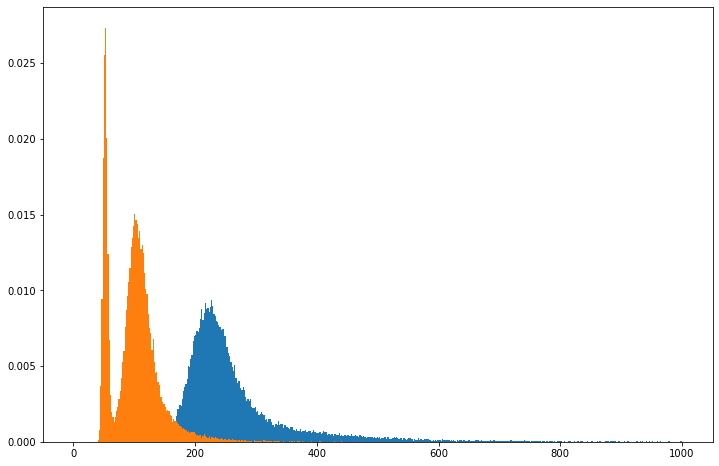

In [4]:
ch33_ped_LG = 51.6
ch33_IC = 9.94

ch34_ped_LG = 51.8
ch34_IC = 9.46


#_ = plt.hist((df[(df.channel == 33)].LG - ch33_ped_LG) * ch33_IC / 26.8, bins=1000, range = (0, 149))
#_ = plt.hist((df[(df.channel == 34)].LG - ch34_ped_LG) * ch34_IC / 34.7, bins=1000, range = (0, 149))

con33, bins33, _ = plt.hist(df[(df.channel == 33)].LG, bins=500, range = (0, 1000), density = True)
con34, bins34, _ = plt.hist(df[(df.channel == 34)].LG, bins=500, range = (0, 1000), density = True)




[6.30556772e+01 4.20445468e+00 8.71796735e+00 8.88344413e-03]
[13.82452846  1.55906694  3.45753894  0.01455222]


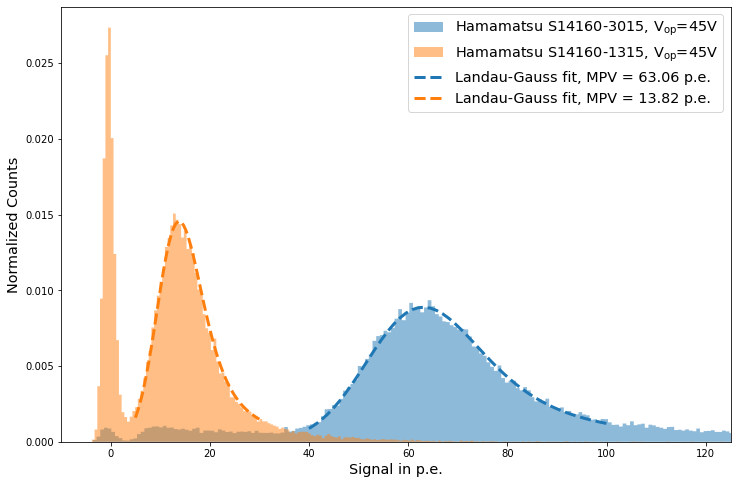

In [5]:
bins33c = (bins33[:-1] - ch33_ped_LG)*ch33_IC/26.8
bins34c = (bins34[:-1] - ch34_ped_LG)*ch34_IC/34.7

plt.fill_between(bins33c, con33, step='pre', alpha = 0.5, label = "Hamamatsu S14160-3015, V${}_{\mathrm{op}}$=45V")
plt.fill_between(bins34c, con34, step='pre', alpha = 0.5, label = "Hamamatsu S14160-1315, V${}_{\mathrm{op}}$=45V")

#plt.step((bins33[:-1] - ch33_ped_LG)*ch33_IC/26.8, con33, where='pre', label='ch33')
#plt.step((bins34[:-1] - ch34_ped_LG)*ch34_IC/34.7, con34, where='pre', label='ch34')

x33 = np.linspace(40, 100)
mask33 = (bins33c>40) & (bins33c<80)

x34 = np.linspace(5, 30)
mask34 = (bins34c>5) & (bins34c<30)

#plt.plot(x34, pylandau.langau(x34, 13, 2, 2, 0.015), label='ch33')

r33, c33 = scipy.optimize.curve_fit(pylandau.langau, bins33c[mask33], con33[mask33], p0=(62, 8, 5, 0.008))
print(r33)
plt.plot(x33, pylandau.langau(x33,*r33), lw = 3, ls = '--', label=f'Landau-Gauss fit, MPV = {r33[0]:.2f} p.e.')

r34, c34 = scipy.optimize.curve_fit(pylandau.langau, bins34c[mask34], con34[mask34], p0=(13, 2, 2, 0.015))
print(r34)
plt.plot(x34, pylandau.langau(x34,*r34), lw = 3, ls = '--', label=f'Landau-Gauss fit, MPV = {r34[0]:.2f} p.e.')


plt.xlim(-10, 125)
plt.ylim(0)

plt.xlabel('Signal in p.e.')
plt.ylabel('Normalized Counts')

plt.legend(fontsize = 'x-large')
#plt.savefig('MIP_MPV.pdf')